In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.3.0
TFP version: 0.11.0


In [2]:
# Additional imports and setting fixed random seed to have reproducibility

import matplotlib.pyplot as plt
import numpy as np
tf.random.set_seed(123)

In [3]:
# Load CIFAR10 Dataset

from tensorflow.keras.datasets import cifar10

# Preprocessing Data

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

normalize =False
if normalize:
    x_train = x_train/255.0
    x_test = x_test/255.0

In [5]:
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
# Predecided options

img_shape = x_train.shape[1:]
num_classes = len(cifar_labels)

# Smoothing Parameter
alpha = 1e-6

# No of Bins
n_bins = 32

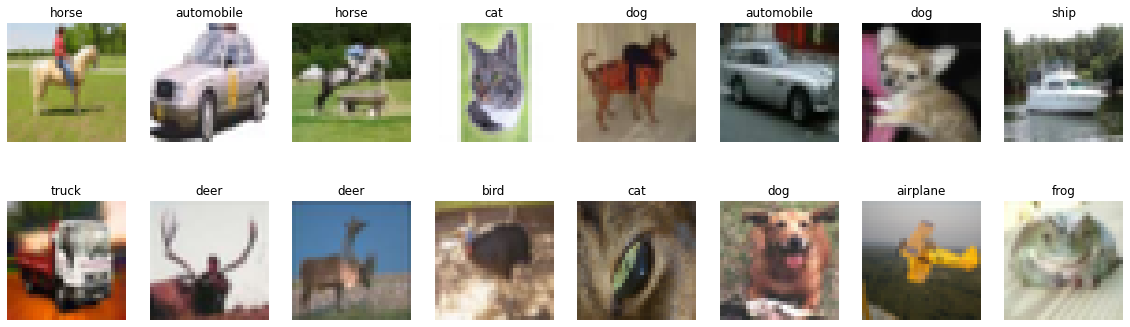

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(20,6))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        idx = np.random.randint(0,x_train.shape[0])
        ax[i, j].imshow(x_train[idx])
        ax[i, j].set_title(cifar_labels[y_train[idx]])
        ax[i, j].axis("off")

# Utility Functions

In [8]:
# Function to divide Data in Bins

binned_data = lambda data, n_bins: np.digitize(data, np.arange(0,256,256/n_bins)) - 1   

In [9]:
def initiate_parameters(x_data, y_data, alpha):
    """
    DESCR:
      This function calculates represents P(X|Y) where X is a Multivariate Random Variable.

    INPUT:
    - x_data: Images Data divided in bins.
    - y_data: Image Labels
    - alpha: The smoothing parameter for Laplacian smoothing.
    
    OUTPUT:
    - output: Parametrs of the Data with shape [num_classes, img_height, img_width, channels, n_bins]
    """
    theta = np.ones(shape=(num_classes, *img_shape, n_bins))*alpha

    for c_num in range(num_classes):
        for b_num in range(n_bins):
            mask = (y_data == c_num)
            theta[c_num, :,:,:, b_num] = (x_data[mask] == b_num).sum(axis=0)

        # Normaliae values over bins for agiven class.
        theta[c_num] /= theta[c_num].sum(axis=-1)[:,:,:,np.newaxis]

    return theta

In [10]:
# Visualization of the Parameters

def visualize(theta):
    fig, ax = plt.subplots(nrows=theta.shape[0], ncols=theta.shape[-1], figsize=(20,20))

    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].matshow(theta[i, :,:,:, j])
            ax[i, j].set_title("{}_bin_{}".format(cifar_labels[i], int(j+1)))
            ax[i, j].axis("off")
    fig.show()

In [11]:
def class_priors(num_classes, labels):
    priors = np.zeros(shape=(num_classes,))
    for c_num in range(num_classes):
        priors[c_num] = np.sum(c_num == y_train)
    priors /= np.sum(priors)
    return priors

In [12]:
# Now we will do a function that given the feature occurence counts returns a Categeorical distribution of 
# batch_shape=number of classes and event_shape=number of pixels in image.

def make_distribution(probs):
    batch_of_categoerical = tfd.Categorical(probs=probs)
    dist = tfd.Independent(batch_of_categoerical, 
                           reinterpreted_batch_ndims=3)

    return dist

In [13]:
# The final function predict_sample which given the distribution, a test sample, and the class priors:
#   1) Computes the class conditional probabilities given the sample
#   2) Forms the joint likelihood
#   3) Normalises the joint likelihood and returns the log prob

def predict_sample(dist, sample, priors):
    cond_probs = dist.log_prob(sample)
    joint_likelihood = tf.add(np.log(priors), cond_probs)
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
    log_probs = joint_likelihood - norm_factor

    return log_probs

# Training

In [14]:
# Divide data into bins.

x_train_binned = binned_data(x_train, n_bins) 
x_test_binned = binned_data(x_test, n_bins)

print("Bins:", np.arange(0, 256, 256/n_bins))

Bins: [  0.   8.  16.  24.  32.  40.  48.  56.  64.  72.  80.  88.  96. 104.
 112. 120. 128. 136. 144. 152. 160. 168. 176. 184. 192. 200. 208. 216.
 224. 232. 240. 248.]


In [15]:
# Genrate the Probabilities from the training data.

theta = initiate_parameters(x_train_binned, y_train, alpha)

if n_bins<10:
    visualize(theta)

In [16]:
# Create Categeorical distribution fom probabilities

tf_dist = make_distribution(theta)
tf_dist

<tfp.distributions.Independent 'IndependentCategorical' batch_shape=[10] event_shape=[32, 32, 3] dtype=int32>

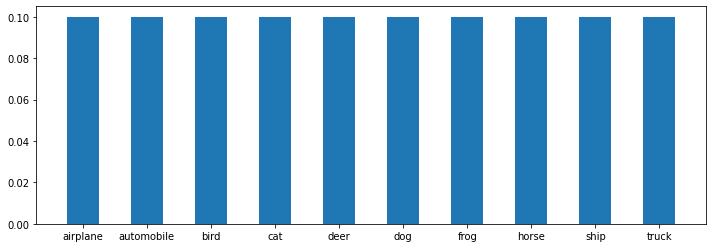

In [17]:
priors = class_priors(num_classes, y_train)

# Visualize the Priors
plt.figure(figsize=(12, 4))
plt.bar(cifar_labels, priors, width=0.5)
plt.show()

In [18]:
# Predicting one example from our test data

log_probs = predict_sample(tf_dist, x_test_binned[0], priors)
log_probs

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-7.3453516e+02, -3.3613086e+02, -6.2354492e+01, -2.2670801e+02,
       -1.9453125e+00, -2.0841895e+02, -1.5429688e-01, -3.1214844e+02,
       -4.2912109e+02, -5.4274414e+02], dtype=float32)>

# Testing

In [19]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

In [20]:
# Loop over our test data and classify.

probabilities = []
for sample, label in zip(x_test_binned, y_test):
    probabilities.append(tf.exp(predict_sample(tf_dist, sample, priors)))

probabilities = np.asarray(probabilities)
predicted_classes = np.argmax(probabilities, axis =-1)

print('F1 Score: {:10f}%'.format(100*f1_score(y_test, predicted_classes, average='macro')))
print('Precision Score: {:10f}%'.format(100* precision_score(y_test, predicted_classes, average='macro', zero_division=0)))
print('Recall Score: {:10f}%'.format(100*recall_score(y_test, predicted_classes, average='macro')))
print('Confsion Metrix: \n{}'.format(confusion_matrix(y_test, predicted_classes)))

F1 Score:  29.304997%
Precision Score:  31.574170%
Recall Score:  30.600000%
Confsion Metrix: 
[[480  27  47  17  84  31  39  10 211  54]
 [101 220  50  57  77  60 109  24 111 191]
 [213  42 134  36 294  40 139  21  54  27]
 [145  47  84 120 180 112 177  35  44  56]
 [ 75  12 105  48 441  43 183  18  55  20]
 [144  31  90  76 168 248 118  45  52  28]
 [ 89  23 101  43 262  43 370  11  21  37]
 [117  29  70  49 229  95  66 156  67 122]
 [135  54  39  22  57  72  29  10 496  86]
 [113  85  36  28  59  34  61  32 157 395]]


In [21]:
# Make a Categeorical Naive Bayes classifier using sklearn with the same level of alpha smoothing. 

clf = CategoricalNB(alpha=alpha)
clf.fit(x_train_binned.reshape(-1,32*32*3), y_train)
pred = clf.predict(x_test_binned.reshape(-1,32*32*3))


print('F1 Score: {:10f}%'.format(100*f1_score(y_test, pred, average='macro')))
print('Precision Score: {:10f}%'.format(100* precision_score(y_test, pred, average='macro', zero_division=0)))
print('Recall Score: {:10f}%'.format(100*recall_score(y_test, pred, average='macro')))
print('Confsion Metrix: \n{}'.format(confusion_matrix(y_test, pred)))

F1 Score:  29.304997%
Precision Score:  31.574170%
Recall Score:  30.600000%
Confsion Metrix: 
[[480  27  47  17  84  31  39  10 211  54]
 [101 220  50  57  77  60 109  24 111 191]
 [213  42 134  36 294  40 139  21  54  27]
 [145  47  84 120 180 112 177  35  44  56]
 [ 75  12 105  48 441  43 183  18  55  20]
 [144  31  90  76 168 248 118  45  52  28]
 [ 89  23 101  43 262  43 370  11  21  37]
 [117  29  70  49 229  95  66 156  67 122]
 [135  54  39  22  57  72  29  10 496  86]
 [113  85  36  28  59  34  61  32 157 395]]
